In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as mp
import keras.datasets as kdat
from skimage.filters import threshold_mean
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

Using TensorFlow backend.


In [5]:
# tf.enable_eager_execution()
jtplot.style()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [6]:
class HAM:
    
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data = len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        
        # Hebb rule
        for i in tqdm(range(num_data), leave=False):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W
        
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        # Copy to avoid call by reference 
        copied_data = np.copy(data)
        
        # Define predict list
        predicted = []
        for i in tqdm(range(len(data)), leave=False):
            predicted.append(self._run(copied_data[i]))
            
        return predicted
    
    def _run(self, init_s):
        if self.asyn == False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)
            
            # Iteration
            for i in tnrange(self.num_iter, leave=False):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            # Iteration
            for i in tnrange(self.num_iter, leave=False):
                for j in tnrange(100, leave=False):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron) 
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self):
        mp.figure(figsize=(16/2, 16/2))
        w_mat = mp.imshow(self.W, cmap='gray')
        mp.colorbar(w_mat)
        mp.title("Network Weights")
        mp.grid(False)
#         mp.tight_layout()
#         mp.savefig("weights.png")
        mp.show()
    

# Utils
def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data

def plot(data, test, predicted, figsize=(5*3, 5*3)):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    
    fig, axarr = mp.subplots(3, 3, figsize=figsize)
    for i in range(3):
        if i==0:
            axarr[i, 0].set_title('Train data')
            axarr[i, 1].set_title("Input data")
            axarr[i, 2].set_title('Output data')
            
        axarr[i, 0].imshow(data[i])
        axarr[i, 0].axis('off')
        axarr[i, 1].imshow(test[i])
        axarr[i, 1].axis('off')
        axarr[i, 2].imshow(predicted[i])
        axarr[i, 2].axis('off')
            
    mp.grid(False)
#     mp.tight_layout()
    mp.savefig('190827-hopfield_output.png', dpi=300, bbox_inches='tight', transparent=True)
    mp.show()

def preprocessing(img):
    w, h = img.shape
    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolean to int
    
    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data
    (x_train, y_train), (_, _ )= kdat.mnist.load_data()
    data = []
    for _ in range(100):
        for i in range(3):
            xi = x_train[y_train==i]
            data.append(xi[0])
    
    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]
    
    # Create Hopfield Network Model
    model = HAM()
    model.train_weights(data)
    
    # Make test datalist
    test = []
    for i in tnrange(3):
        xi = x_train[y_train==i]
        p = 0.90
        mask = rand.choice([0, 1], xi[1].shape, p=[1-p, p])
        xi = xi[1]*mask
        test.append(xi)
    test = [preprocessing(d) for d in test]
    
    predicted = model.predict(test, num_iter=100, threshold=50, asyn=True)
    print("Show prediction results...")
    plot(data, test, predicted, figsize=(5, 5))
    print("Show network weights matrix...")
    model.plot_weights()

Start to data preprocessing...
Start to train weights...



Start to predict...


Show prediction results...


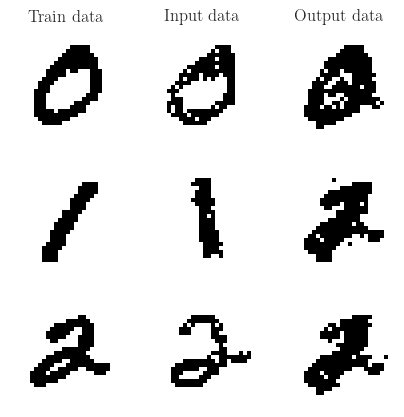

Show network weights matrix...


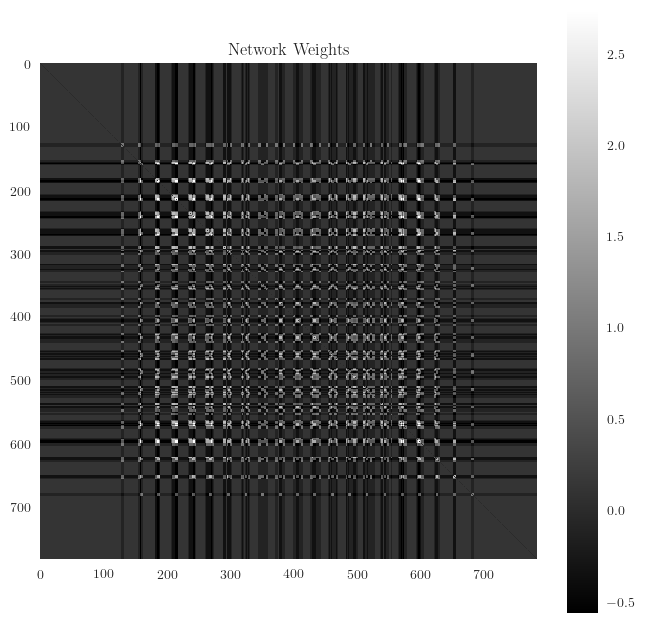

In [7]:
main()